In [26]:
# https://workingwithpython.com/pythoncohortanalysis/
import pandas as pd

In [27]:
df=pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true', 
                 sheet_name='Purchase Data - Full Study')
df.head()

C:\Users\Jinyoung\.conda\envs\py3_7_6\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   CommonId      2891 non-null   object        
 5   PupId         2891 non-null   int64         
 6   PickupDate    2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 158.2+ KB


In [29]:
df.drop(['CommonId', 'PupId', 'PickupDate', 'TotalCharges'], axis=1, inplace=True)
df.head()

,OrderId,OrderDate,UserId
0,262,2009-01-11,47
1,278,2009-01-20,47
2,294,2009-02-03,47
3,301,2009-02-06,47
4,302,2009-02-06,47


## 주문일자 칼럼으로 단위기간 만들기

In [30]:
# 코호트 분석시 데이터 집계를 위한 단위기간은 보통 월단위
df['OrderDate'].head()

0   2009-01-11
1   2009-01-20
2   2009-02-03
3   2009-02-06
4   2009-02-06
Name: OrderDate, dtype: datetime64[ns]

In [31]:
df['OrderDate'].dtype

dtype('<M8[ns]')

In [32]:
df['OrderPeriod'] = df['OrderDate'].dt.strftime("%Y-%m")

In [33]:
df.head()

,OrderId,OrderDate,UserId,OrderPeriod
0,262,2009-01-11,47,2009-01
1,278,2009-01-20,47,2009-01
2,294,2009-02-03,47,2009-02
3,301,2009-02-06,47,2009-02
4,302,2009-02-06,47,2009-02


## 유저의 첫 번째 주문을 토대로 유저별 코호트 그룹 설정

In [34]:
df.set_index('UserId', inplace=True)
df.head()

,OrderId,OrderDate,OrderPeriod
UserId,,,
47,262,2009-01-11,2009-01
47,278,2009-01-20,2009-01
47,294,2009-02-03,2009-02
47,301,2009-02-06,2009-02
47,302,2009-02-06,2009-02


In [35]:
FirstOrder = df.groupby(df.index)['OrderDate'].min()
FirstOrder.head()

UserId
47    2009-01-11
95    2009-03-10
98    2009-01-29
112   2009-01-19
141   2009-11-13
Name: OrderDate, dtype: datetime64[ns]

In [36]:
FirstOrder = FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

UserId
47     2009-01
95     2009-03
98     2009-01
112    2009-01
141    2009-11
Name: OrderDate, dtype: object

In [37]:
df['FirstOrder'] = FirstOrder

In [38]:
df.reset_index(inplace=True)

In [39]:
df.head()

,UserId,OrderId,OrderDate,OrderPeriod,FirstOrder
0,47,262,2009-01-11,2009-01,2009-01
1,47,278,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,2009-02,2009-01
3,47,301,2009-02-06,2009-02,2009-01
4,47,302,2009-02-06,2009-02,2009-01


## 코호트 그룹과 주문기간으로 데이터 집계

In [40]:
grouped = df.groupby(['FirstOrder', 'OrderPeriod'])
cohorts = grouped['UserId'].nunique() # 순방문자수
cohorts.head()

FirstOrder  OrderPeriod
2009-01     2009-01        22
            2009-02         8
            2009-03        10
            2009-04         9
            2009-05        10
Name: UserId, dtype: int64

In [43]:
cohorts = cohorts.reset_index()
cohorts.head()

,FirstOrder,OrderPeriod,UserId
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


In [44]:
cohorts.rename({'UserId':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


## 데이터가 없는 기간 체크 및 데이터 전처리

In [45]:
each_period = cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    13
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

In [46]:
cohorts[cohorts['FirstOrder']=='2009-02']


,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15
16,2009-02,2009-03,3
17,2009-02,2009-04,5
18,2009-02,2009-05,1
19,2009-02,2009-06,4
20,2009-02,2009-07,4
21,2009-02,2009-08,4
22,2009-02,2009-09,5
23,2009-02,2009-10,5
24,2009-02,2009-11,4


In [47]:
cohorts[cohorts['FirstOrder']=='2009-04'].tail()

,FirstOrder,OrderPeriod,TotalUsers
48,2009-04,2009-11,6
49,2009-04,2009-12,2
50,2009-04,2010-01,4
51,2009-04,2010-02,3
52,2009-04,2010-03,2


In [49]:
cohorts[cohorts['FirstOrder']=='2009-05'].tail()

,FirstOrder,OrderPeriod,TotalUsers
59,2009-05,2009-11,3
60,2009-05,2009-12,5
61,2009-05,2010-01,5
62,2009-05,2010-02,4
63,2009-05,2010-03,3


In [50]:
cohorts.loc[cohorts.shape[0],'FirstOrder']='2009-02'
cohorts.loc[cohorts.shape[0]-1,'OrderPeriod']='2010-03'
cohorts.loc[cohorts.shape[0]-1,'TotalUsers']=0
cohorts.sort_values(['FirstOrder','OrderPeriod'],inplace=True)

In [59]:
cohorts[cohorts['FirstOrder']=='2009-02']

,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15.0
16,2009-02,2009-03,3.0
17,2009-02,2009-04,5.0
18,2009-02,2009-05,1.0
19,2009-02,2009-06,4.0
20,2009-02,2009-07,4.0
21,2009-02,2009-08,4.0
22,2009-02,2009-09,5.0
23,2009-02,2009-10,5.0
24,2009-02,2009-11,4.0


In [63]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    14
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

## 기간별 레이블 붙이기

In [64]:
cohortperiod = []

for x in each_period:
    for y in range(x):
        cohortperiod.append(y)

In [65]:
cohorts['CohortPeriod'] = cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2009-01,2009-01,22.0,0
1,2009-01,2009-02,8.0,1
2,2009-01,2009-03,10.0,2
3,2009-01,2009-04,9.0,3
4,2009-01,2009-05,10.0,4
5,2009-01,2009-06,8.0,5
6,2009-01,2009-07,8.0,6
7,2009-01,2009-08,7.0,7
8,2009-01,2009-09,7.0,8
9,2009-01,2009-10,7.0,9


In [66]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2009-01    0                2009-01        22.0
           1                2009-02         8.0
           2                2009-03        10.0
           3                2009-04         9.0
           4                2009-05        10.0

In [67]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,0.0,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 코호트별 사용자 유지율

In [68]:
cohorts[0]

FirstOrder
2009-01     22.0
2009-02     15.0
2009-03     13.0
2009-04     39.0
2009-05     50.0
2009-06     32.0
2009-07     50.0
2009-08     31.0
2009-09     37.0
2009-10     54.0
2009-11    130.0
2009-12     65.0
2010-01     95.0
2010-02    100.0
2010-03     24.0
Name: 0, dtype: float64

In [69]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,0.000000,NaN
2009-03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009-04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009-05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009-06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 코호트 시각화

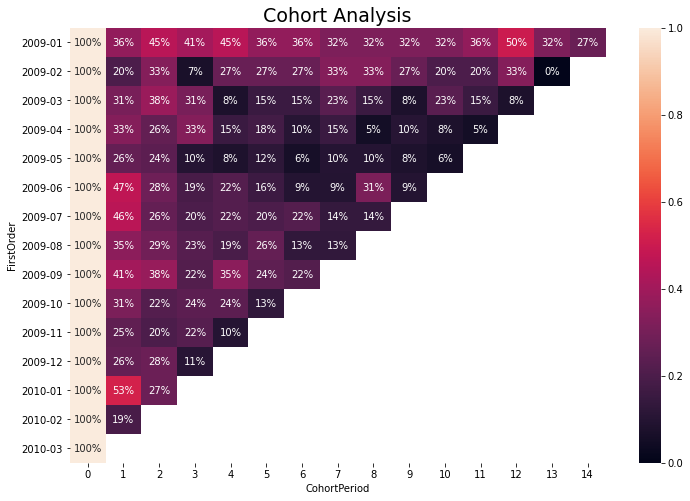

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=19)
sns.heatmap(user_retention, annot=True, fmt='.0%')
plt.show()